In [1]:
def mseplot(history, lb, ub, font, ep1, ep2):
    plt.figure(figsize=(14,8))
    plt.plot(history.history['loss'],'-o')
    plt.plot(history.history['val_loss'],'-s')
    plt.title('MSE loss for Damage localization (1DCNN)',fontsize=font+2)
    plt.ylabel('MSE',fontsize=font)
    plt.xticks(fontsize=font)
    plt.yticks(fontsize=font)
    plt.xlabel('Number of epochs',fontsize=font)
    plt.legend(['train', 'test'], loc='upper right',fontsize=font)
    plt.axis([ep1,ep2,lb,ub])
    return plt.show()

def maeplot(history, lb, ub, font, ep1, ep2):
    plt.figure(figsize=(14,8))
    plt.plot(history.history['mae'],'-o')
    plt.plot(history.history['val_mae'],'-s')
    plt.title('MAE for Damage localization (1DCNN)',fontsize=font+2)
    plt.ylabel('MAE',fontsize=font)
    plt.xticks(fontsize=font)
    plt.yticks(fontsize=font)
    plt.xlabel('Number of epochs',fontsize=font)
    plt.legend(['train', 'test'], loc='upper right',fontsize=font)
    plt.axis([ep1,ep2,lb,ub])
    return plt.show()

def mapeplot(history, lb, ub, font, ep1, ep2):
    plt.figure(figsize=(14,8))
    plt.plot(history.history['mape'],'-o')
    plt.plot(history.history['val_mape'],'-s')
    plt.title('MAPE for Damage localization (1DCNN)',fontsize=font+2)
    plt.ylabel('MAPE',fontsize=font)
    plt.xticks(fontsize=font)
    plt.yticks(fontsize=font)
    plt.xlabel('Number of epochs',fontsize=font)
    plt.legend(['train', 'test'], loc='upper right',fontsize=font)
    plt.axis([ep1,ep2,lb,ub])
    return plt.show()

def r2plot(history, lb, ub, font, ep1, ep2):
    plt.figure(figsize=(14,8))
    plt.plot(history.history['r_square'],'-o')
    plt.plot(history.history['val_r_square'],'-s')
    plt.title('R^2 for Damage localization (1DCNN)',fontsize=font+2)
    plt.ylabel('R^2',fontsize=font)
    plt.xticks(fontsize=font)
    plt.yticks(fontsize=font)
    plt.xlabel('Number of epochs',fontsize=font)
    plt.legend(['train', 'test'], loc='upper right',fontsize=font)
    plt.axis([ep1,ep2,lb,ub])
    return plt.show()

In [2]:
# R^2 coefficient for variance
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()))

In [3]:
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [4]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import glob
import cv2
import os

def load_labels(inputPath):
	# initialize the list of column names in the CSV file and then
	# load it using Pandas
	cols = ["x", "a"]
	df = pd.read_csv(inputPath, header=None, names=cols)
	# return the data frame
	return df

In [5]:
def load_images(df,path):
    images = []
    df = pd.DataFrame(df)
    for i in df.index.values:
        base = os.path.sep.join([path, "Dn{}.png".format(i + 1)])
        #print(base)
        image = cv2.imread(base) # read the path using opencv
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (150, 150))
        images.append(image) 
    return np.array(images)

0
D:/SDE/1_SDEisotropicDL/CollectData/3_CWT/00WithNoise\Dn1.png
1
D:/SDE/1_SDEisotropicDL/CollectData/3_CWT/00WithNoise\Dn2.png


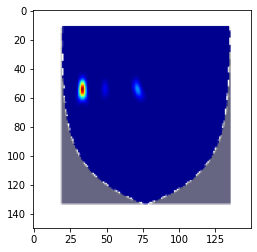

In [6]:
import matplotlib.pyplot as plt
import random
images = []
path = 'D:/SDE/1_SDEisotropicDL/CollectData/3_CWT/00WithNoise'
for i in range(2):
    print(i)
    base = os.path.sep.join([path, "Dn{}.png".format(i + 1)])
    print(base)
    image0 = cv2.imread(base)
    image0 = cv2.cvtColor(image0, cv2.COLOR_BGR2RGB)
    image0 = cv2.resize(image0, (150, 150))
    plt.imshow(image0)
    images.append(image0)

In [7]:
np.array(images).shape

(2, 150, 150, 3)

In [8]:
# import the necessary packages
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model

def create_cnn(width, height, depth, filters=(16, 32, 64, 128, 256)):
	# initialize the input shape and channel dimension, assuming
	# TensorFlow/channels-last ordering
	inputShape = (height, width, depth)
	chanDim = -1

	# define the model input
	inputs = Input(shape=inputShape)

	# loop over the number of filters
	for (i, f) in enumerate(filters):
		# if this is the first CONV layer then set the input
		# appropriately
		if i == 0:
			x = inputs

		# CONV => RELU => BN => POOL
		x = Conv2D(f, (3, 3), padding="same")(x)
		x = Activation("relu")(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = MaxPooling2D(pool_size=(2, 2))(x)

	# flatten the volume, then FC => RELU => BN => DROPOUT
	x = Flatten()(x)

	# construct the CNN
	model = Model(inputs, x)

	# return the CNN
	return model

Using TensorFlow backend.


In [9]:
# import the necessary packages
from sklearn.model_selection import train_test_split
from keras.layers.core import Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import concatenate
import numpy as np
import argparse
import locale
import os

# construct the path to the input .txt file that contains information
# on each house in the dataset and then load the dataset
mainpath = 'D:/SDE/1_SDEisotropicDL/CollectData/2_Labels/labelsD.csv'
path = 'D:/SDE/1_SDEisotropicDL/CollectData/3_CWT/00WithNoise'
inputPath = os.path.join(mainpath)
df = load_labels(inputPath)*1000
df = np.concatenate([df,df,df,df], axis=0) # 3 different noise are added into the dataset

In [10]:
df

array([[100.      ,   5.      ],
       [100.      ,   6.938776],
       [100.      ,   8.877551],
       ...,
       [850.      ,  96.122449],
       [850.      ,  98.061224],
       [850.      , 100.      ]])

In [11]:
# load the images and then scale the pixel intensities to the
# range [0, 1]
print("[INFO] loading images...")
images = load_images(df, path)
images = images / 255.0

[INFO] loading images...


In [12]:
# partition the data into training and testing splits using 95% of
# the data for training and the remaining 5% for testing
# Out of 95%, divide the data 10% to validation and 90% to training

split1 = train_test_split(df, images, test_size=0.05, random_state=42)
(trainAttr1, testAttr, trainImages1, testImages) = split1

split2 = train_test_split(trainAttr1, trainImages1, test_size=0.10, random_state=42)
(trainAttr, validAttr, trainImages, validImages) = split2

trainY = trainAttr
validY = validAttr
testY = testAttr

In [13]:
# create the MLP and CNN models
cnn2d = create_cnn(150,150,3)

# create the input to our final set of layers as the *output* of both
Input = cnn2d.output

# our final FC layer head will have two dense layers, the final one
# being our regression head
x = Dense(512, activation="relu")(Input)
x = Dropout(0.25)(x)
x = Dense(128, activation="relu")(Input)
x = Dropout(0.2)(x)
x = Dense(2, activation="linear")(x)

# our final model will accept categorical/numerical data on the MLP
# input and images on the CNN input, outputting a single value (the
# predicted price of the house)
model = Model(inputs=cnn2d.input, outputs=x)

# compile the model using mean absolute percentage error as our loss,
# implying that we seek to minimize the absolute percentage difference
# between our price *predictions* and the *actual prices*
opt = Adam(lr=1e-5)
model.compile(loss="mse", optimizer=opt, metrics = ['mape','mae',r_square])

In [14]:
print("Training images...",trainImages.shape)
print("Validation images...",validImages.shape)
print("Test images..",testImages.shape)
print("Training labels..",trainY.shape)
print("Validation labels..",validY.shape)
print("Test labels..",testY.shape)

Training images... (8550, 150, 150, 3)
Validation images... (950, 150, 150, 3)
Test images.. (500, 150, 150, 3)
Training labels.. (8550, 2)
Validation labels.. (950, 2)
Test labels.. (500, 2)


In [15]:
trainY

array([[298.979592,  68.979592],
       [834.693878,  63.163265],
       [191.836735,  59.285714],
       ...,
       [559.183673,  78.673469],
       [666.326531,  90.306122],
       [834.693878,  84.489796]])

In [16]:
# train the model
print("[INFO] training model...")
history = model.fit(trainImages, trainY, validation_data = (validImages,validY), epochs=500, batch_size=32, verbose = 2)

[INFO] training model...
Train on 8550 samples, validate on 950 samples
Epoch 1/500
 - 15s - loss: 107255.9248 - mape: 100.7766 - mae: 229.7160 - r_square: -5.4467e-01 - val_loss: 136166.6922 - val_mape: 98.0167 - val_mae: 260.8041 - val_r_square: -9.6121e-01
Epoch 2/500
 - 12s - loss: 64650.6284 - mape: 93.7790 - mae: 176.6856 - r_square: 0.0705 - val_loss: 80085.5279 - val_mape: 87.2525 - val_mae: 195.1454 - val_r_square: -1.4929e-01
Epoch 3/500
 - 12s - loss: 41461.1954 - mape: 82.7335 - mae: 142.1341 - r_square: 0.4059 - val_loss: 39423.7756 - val_mape: 60.2919 - val_mae: 135.3840 - val_r_square: 0.4361
Epoch 4/500
 - 12s - loss: 26686.7004 - mape: 72.5408 - mae: 113.1935 - r_square: 0.6185 - val_loss: 21417.4447 - val_mape: 52.9784 - val_mae: 99.5952 - val_r_square: 0.6932
Epoch 5/500
 - 12s - loss: 16091.6188 - mape: 72.1873 - mae: 87.0810 - r_square: 0.7708 - val_loss: 12247.5655 - val_mape: 54.4963 - val_mae: 74.4033 - val_r_square: 0.8237
Epoch 6/500
 - 13s - loss: 10547.7029 

Epoch 49/500
 - 13s - loss: 1539.9335 - mape: 50.8173 - mae: 28.2891 - r_square: 0.9776 - val_loss: 413.2530 - val_mape: 34.8412 - val_mae: 13.3836 - val_r_square: 0.9941
Epoch 50/500
 - 13s - loss: 1523.1823 - mape: 50.1239 - mae: 27.9625 - r_square: 0.9779 - val_loss: 509.3144 - val_mape: 36.0080 - val_mae: 16.2222 - val_r_square: 0.9927
Epoch 51/500
 - 13s - loss: 1523.0624 - mape: 50.0780 - mae: 28.0693 - r_square: 0.9778 - val_loss: 402.7458 - val_mape: 33.2714 - val_mae: 13.0042 - val_r_square: 0.9943
Epoch 52/500
 - 13s - loss: 1466.1451 - mape: 49.4401 - mae: 27.5730 - r_square: 0.9787 - val_loss: 443.8813 - val_mape: 34.9218 - val_mae: 13.7697 - val_r_square: 0.9937
Epoch 53/500
 - 13s - loss: 1458.3785 - mape: 49.8174 - mae: 27.4600 - r_square: 0.9788 - val_loss: 662.0435 - val_mape: 34.4334 - val_mae: 19.0315 - val_r_square: 0.9905
Epoch 54/500
 - 13s - loss: 1424.4382 - mape: 48.3182 - mae: 27.0553 - r_square: 0.9791 - val_loss: 433.0951 - val_mape: 35.7210 - val_mae: 13.59

Epoch 97/500
 - 13s - loss: 1076.0122 - mape: 38.1023 - mae: 23.0251 - r_square: 0.9844 - val_loss: 759.5054 - val_mape: 27.9079 - val_mae: 20.9844 - val_r_square: 0.9890
Epoch 98/500
 - 13s - loss: 1099.0977 - mape: 38.3527 - mae: 23.3427 - r_square: 0.9839 - val_loss: 229.7935 - val_mape: 25.3938 - val_mae: 9.8117 - val_r_square: 0.9967
Epoch 99/500
 - 12s - loss: 1080.6254 - mape: 37.6544 - mae: 23.1878 - r_square: 0.9843 - val_loss: 332.4228 - val_mape: 26.5613 - val_mae: 12.8212 - val_r_square: 0.9953
Epoch 100/500
 - 13s - loss: 1070.4305 - mape: 37.4446 - mae: 22.9468 - r_square: 0.9843 - val_loss: 216.0038 - val_mape: 25.2116 - val_mae: 9.3448 - val_r_square: 0.9969
Epoch 101/500
 - 13s - loss: 1090.3658 - mape: 36.9117 - mae: 22.9194 - r_square: 0.9842 - val_loss: 273.7504 - val_mape: 25.9730 - val_mae: 10.6227 - val_r_square: 0.9961
Epoch 102/500
 - 13s - loss: 1084.1730 - mape: 37.5837 - mae: 23.0016 - r_square: 0.9843 - val_loss: 324.4931 - val_mape: 25.1913 - val_mae: 12.3

Epoch 145/500
 - 12s - loss: 920.2401 - mape: 31.9657 - mae: 20.8417 - r_square: 0.9867 - val_loss: 162.8869 - val_mape: 20.5578 - val_mae: 7.9942 - val_r_square: 0.9977
Epoch 146/500
 - 12s - loss: 934.4476 - mape: 31.2196 - mae: 20.9116 - r_square: 0.9865 - val_loss: 210.7865 - val_mape: 19.9680 - val_mae: 10.0691 - val_r_square: 0.9970
Epoch 147/500
 - 12s - loss: 894.8606 - mape: 31.5118 - mae: 20.6355 - r_square: 0.9870 - val_loss: 188.8483 - val_mape: 19.3932 - val_mae: 9.4406 - val_r_square: 0.9973
Epoch 148/500
 - 13s - loss: 938.5301 - mape: 30.8892 - mae: 20.9455 - r_square: 0.9864 - val_loss: 184.1701 - val_mape: 20.1760 - val_mae: 8.8803 - val_r_square: 0.9974
Epoch 149/500
 - 12s - loss: 925.7626 - mape: 30.3653 - mae: 20.8147 - r_square: 0.9865 - val_loss: 357.3085 - val_mape: 23.0312 - val_mae: 13.7960 - val_r_square: 0.9949
Epoch 150/500
 - 12s - loss: 894.2365 - mape: 30.4241 - mae: 20.5415 - r_square: 0.9870 - val_loss: 163.4192 - val_mape: 21.5181 - val_mae: 7.9908 -

 - 12s - loss: 787.7253 - mape: 25.8432 - mae: 19.0732 - r_square: 0.9886 - val_loss: 211.5192 - val_mape: 17.4623 - val_mae: 10.8186 - val_r_square: 0.9970
Epoch 194/500
 - 13s - loss: 796.7875 - mape: 26.2967 - mae: 19.2273 - r_square: 0.9884 - val_loss: 152.2361 - val_mape: 19.5420 - val_mae: 7.8340 - val_r_square: 0.9978
Epoch 195/500
 - 12s - loss: 801.9620 - mape: 25.7856 - mae: 19.1862 - r_square: 0.9884 - val_loss: 127.1006 - val_mape: 16.0068 - val_mae: 7.1719 - val_r_square: 0.9982
Epoch 196/500
 - 13s - loss: 803.1531 - mape: 25.7807 - mae: 19.1146 - r_square: 0.9884 - val_loss: 134.8841 - val_mape: 15.7757 - val_mae: 7.7265 - val_r_square: 0.9981
Epoch 197/500
 - 13s - loss: 803.9539 - mape: 25.9597 - mae: 19.1300 - r_square: 0.9883 - val_loss: 139.7436 - val_mape: 17.3609 - val_mae: 7.8035 - val_r_square: 0.9980
Epoch 198/500
 - 13s - loss: 801.1726 - mape: 25.7492 - mae: 19.1173 - r_square: 0.9884 - val_loss: 160.0894 - val_mape: 16.7287 - val_mae: 8.6460 - val_r_square: 

Epoch 242/500
 - 12s - loss: 735.1150 - mape: 22.4293 - mae: 17.9874 - r_square: 0.9894 - val_loss: 96.4311 - val_mape: 13.6553 - val_mae: 6.1087 - val_r_square: 0.9986
Epoch 243/500
 - 13s - loss: 716.9902 - mape: 22.3135 - mae: 17.9781 - r_square: 0.9896 - val_loss: 119.4830 - val_mape: 14.3089 - val_mae: 7.2169 - val_r_square: 0.9983
Epoch 244/500
 - 13s - loss: 717.4034 - mape: 22.2517 - mae: 17.9093 - r_square: 0.9896 - val_loss: 138.2262 - val_mape: 14.4557 - val_mae: 8.0603 - val_r_square: 0.9980
Epoch 245/500
 - 12s - loss: 708.8200 - mape: 22.2786 - mae: 17.8672 - r_square: 0.9897 - val_loss: 102.3560 - val_mape: 13.4410 - val_mae: 6.5411 - val_r_square: 0.9985
Epoch 246/500
 - 12s - loss: 727.2957 - mape: 22.5365 - mae: 18.0736 - r_square: 0.9895 - val_loss: 102.0179 - val_mape: 14.5232 - val_mae: 6.5954 - val_r_square: 0.9985
Epoch 247/500
 - 12s - loss: 702.9594 - mape: 21.9421 - mae: 17.8027 - r_square: 0.9898 - val_loss: 128.3337 - val_mape: 14.3407 - val_mae: 7.7174 - va

Epoch 291/500
 - 12s - loss: 679.7161 - mape: 19.6484 - mae: 17.1972 - r_square: 0.9902 - val_loss: 123.9436 - val_mape: 12.1003 - val_mae: 7.3621 - val_r_square: 0.9982
Epoch 292/500
 - 12s - loss: 685.3317 - mape: 19.3389 - mae: 17.1977 - r_square: 0.9901 - val_loss: 100.5899 - val_mape: 12.1111 - val_mae: 6.9441 - val_r_square: 0.9985
Epoch 293/500
 - 12s - loss: 656.3351 - mape: 19.2296 - mae: 16.8583 - r_square: 0.9905 - val_loss: 88.3509 - val_mape: 12.3889 - val_mae: 6.3909 - val_r_square: 0.9987
Epoch 294/500
 - 13s - loss: 641.7005 - mape: 19.4206 - mae: 16.8059 - r_square: 0.9907 - val_loss: 97.2172 - val_mape: 12.1265 - val_mae: 6.6880 - val_r_square: 0.9986
Epoch 295/500
 - 13s - loss: 667.2890 - mape: 19.0958 - mae: 17.0018 - r_square: 0.9903 - val_loss: 130.8621 - val_mape: 12.1706 - val_mae: 8.5571 - val_r_square: 0.9981
Epoch 296/500
 - 13s - loss: 655.0984 - mape: 19.1523 - mae: 16.8904 - r_square: 0.9905 - val_loss: 129.3344 - val_mape: 13.3287 - val_mae: 7.7319 - val

Epoch 340/500
 - 12s - loss: 616.4536 - mape: 17.5347 - mae: 16.1708 - r_square: 0.9911 - val_loss: 208.5999 - val_mape: 11.3022 - val_mae: 10.7786 - val_r_square: 0.9970
Epoch 341/500
 - 13s - loss: 670.5224 - mape: 17.6029 - mae: 16.7656 - r_square: 0.9903 - val_loss: 293.6048 - val_mape: 12.9034 - val_mae: 13.0048 - val_r_square: 0.9957
Epoch 342/500
 - 13s - loss: 649.9554 - mape: 17.6906 - mae: 16.5909 - r_square: 0.9906 - val_loss: 72.3162 - val_mape: 11.0731 - val_mae: 5.4557 - val_r_square: 0.9989
Epoch 343/500
 - 13s - loss: 627.2614 - mape: 17.2555 - mae: 16.3878 - r_square: 0.9909 - val_loss: 78.8685 - val_mape: 10.5539 - val_mae: 5.8335 - val_r_square: 0.9988
Epoch 344/500
 - 13s - loss: 628.1913 - mape: 17.7719 - mae: 16.4167 - r_square: 0.9909 - val_loss: 88.2207 - val_mape: 10.8612 - val_mae: 6.5057 - val_r_square: 0.9987
Epoch 345/500
 - 12s - loss: 620.4442 - mape: 17.2004 - mae: 16.2439 - r_square: 0.9910 - val_loss: 68.2855 - val_mape: 10.7813 - val_mae: 5.2412 - val

Epoch 389/500
 - 13s - loss: 601.0435 - mape: 15.8786 - mae: 15.8411 - r_square: 0.9913 - val_loss: 114.0948 - val_mape: 9.8932 - val_mae: 7.9410 - val_r_square: 0.9983
Epoch 390/500
 - 13s - loss: 612.5769 - mape: 15.8162 - mae: 16.0157 - r_square: 0.9911 - val_loss: 88.7059 - val_mape: 9.3538 - val_mae: 6.8665 - val_r_square: 0.9987
Epoch 391/500
 - 13s - loss: 608.8146 - mape: 16.1169 - mae: 15.8818 - r_square: 0.9912 - val_loss: 69.0252 - val_mape: 10.4681 - val_mae: 5.5660 - val_r_square: 0.9990
Epoch 392/500
 - 13s - loss: 619.5517 - mape: 16.0536 - mae: 16.0196 - r_square: 0.9910 - val_loss: 88.9249 - val_mape: 10.0456 - val_mae: 6.4295 - val_r_square: 0.9987
Epoch 393/500
 - 13s - loss: 599.3855 - mape: 15.8220 - mae: 15.6083 - r_square: 0.9912 - val_loss: 55.0245 - val_mape: 9.3211 - val_mae: 5.0988 - val_r_square: 0.9992
Epoch 394/500
 - 13s - loss: 582.4697 - mape: 15.5191 - mae: 15.5639 - r_square: 0.9916 - val_loss: 268.6763 - val_mape: 11.5116 - val_mae: 11.6577 - val_r_s

Epoch 438/500
 - 13s - loss: 571.9215 - mape: 14.6778 - mae: 15.3675 - r_square: 0.9917 - val_loss: 77.9966 - val_mape: 8.4612 - val_mae: 6.0429 - val_r_square: 0.9989
Epoch 439/500
 - 13s - loss: 579.0275 - mape: 15.0494 - mae: 15.5186 - r_square: 0.9916 - val_loss: 57.7080 - val_mape: 8.7252 - val_mae: 5.2326 - val_r_square: 0.9992
Epoch 440/500
 - 13s - loss: 593.9912 - mape: 14.8946 - mae: 15.5812 - r_square: 0.9914 - val_loss: 53.0057 - val_mape: 8.3111 - val_mae: 4.7708 - val_r_square: 0.9992
Epoch 441/500
 - 13s - loss: 580.6131 - mape: 14.5622 - mae: 15.5119 - r_square: 0.9916 - val_loss: 159.3816 - val_mape: 9.6901 - val_mae: 9.4801 - val_r_square: 0.9977
Epoch 442/500
 - 13s - loss: 580.9567 - mape: 14.7381 - mae: 15.4757 - r_square: 0.9916 - val_loss: 64.7873 - val_mape: 9.1994 - val_mae: 5.4842 - val_r_square: 0.9990
Epoch 443/500
 - 13s - loss: 571.2037 - mape: 14.9595 - mae: 15.3450 - r_square: 0.9917 - val_loss: 65.8864 - val_mape: 9.5989 - val_mae: 5.5873 - val_r_square

Epoch 487/500
 - 13s - loss: 559.2005 - mape: 14.0644 - mae: 15.0875 - r_square: 0.9919 - val_loss: 56.8190 - val_mape: 7.9531 - val_mae: 4.8510 - val_r_square: 0.9992
Epoch 488/500
 - 13s - loss: 551.8397 - mape: 13.6549 - mae: 14.9427 - r_square: 0.9920 - val_loss: 40.2167 - val_mape: 7.7857 - val_mae: 4.1847 - val_r_square: 0.9994
Epoch 489/500
 - 13s - loss: 566.0399 - mape: 14.0578 - mae: 15.2399 - r_square: 0.9918 - val_loss: 54.7566 - val_mape: 7.4152 - val_mae: 4.9773 - val_r_square: 0.9992
Epoch 490/500
 - 13s - loss: 563.8887 - mape: 14.0147 - mae: 15.2539 - r_square: 0.9918 - val_loss: 35.0685 - val_mape: 7.2181 - val_mae: 3.9214 - val_r_square: 0.9995
Epoch 491/500
 - 13s - loss: 570.3786 - mape: 14.0285 - mae: 15.1462 - r_square: 0.9918 - val_loss: 104.1891 - val_mape: 8.2063 - val_mae: 7.0263 - val_r_square: 0.9985
Epoch 492/500
 - 13s - loss: 544.6339 - mape: 13.8596 - mae: 14.8791 - r_square: 0.9922 - val_loss: 52.1899 - val_mape: 8.4657 - val_mae: 5.2949 - val_r_square

In [18]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# or save to csv: 
hist_csv_file = 'history2DCNN.csv'
with open(hist_csv_file, mode='w', newline='') as f:
    hist_df.to_csv(f)

In [19]:
History = pd.read_csv('history2DCNN.csv')
History.shape

(500, 9)

In [20]:
epoch = History.iloc[:,0];
MSE = History.iloc[:,5]/1e6;
MAPE = History.iloc[:,6];
MAE = History.iloc[:,7]/1e3;
R2 = History.iloc[:,8];
MSEval = History.iloc[:,1]/1e6;
MAPEval = History.iloc[:,2];
MAEval = History.iloc[:,3]/1e3;
R2val = History.iloc[:,4];

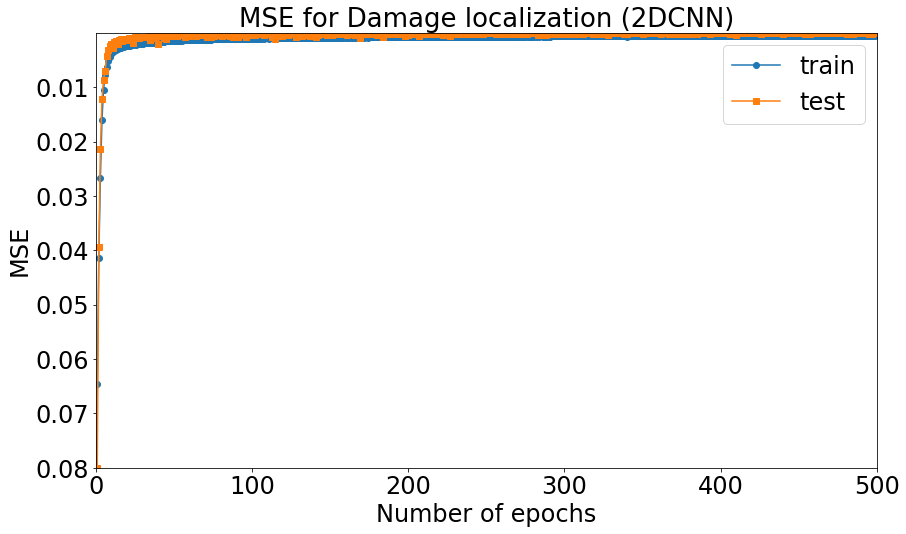

In [22]:
# for mse
plt.figure(figsize=(14,8))
plt.plot(epoch,MSE,'-o')
plt.plot(epoch,MSEval,'-s')
plt.title('MSE for Damage localization (2DCNN)',fontsize=26)
plt.ylabel('MSE',fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel('Number of epochs',fontsize=24)
plt.legend(['train', 'test'], loc='upper right',fontsize=24)
plt.axis([0,500,0.08, 1e-5])
plt.show()

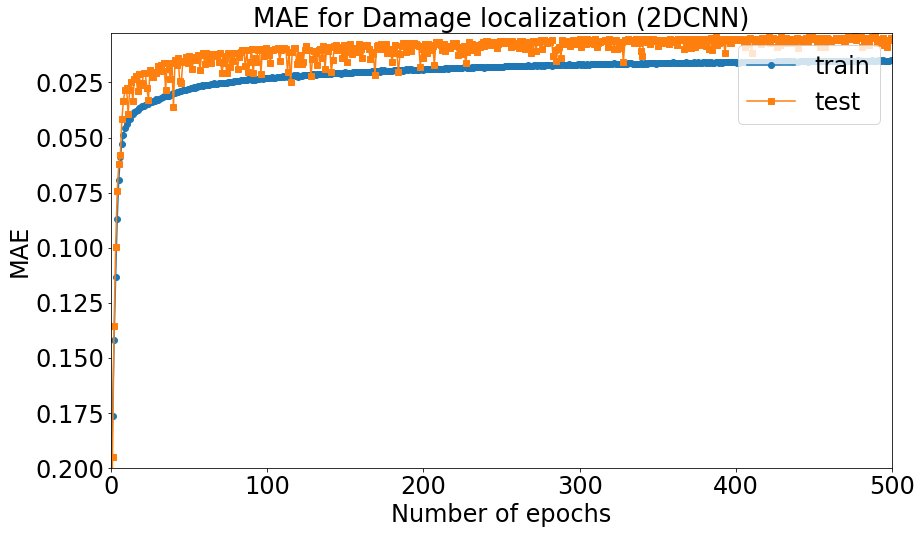

In [26]:
# for mae
plt.figure(figsize=(14,8))
plt.plot(epoch,MAE,'-o')
plt.plot(epoch,MAEval,'-s')
plt.title('MAE for Damage localization (2DCNN)',fontsize=26)
plt.ylabel('MAE',fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel('Number of epochs',fontsize=24)
plt.legend(['train', 'test'], loc='upper right',fontsize=24)
plt.axis([0,500, 0.2, 0.0025])
plt.show()

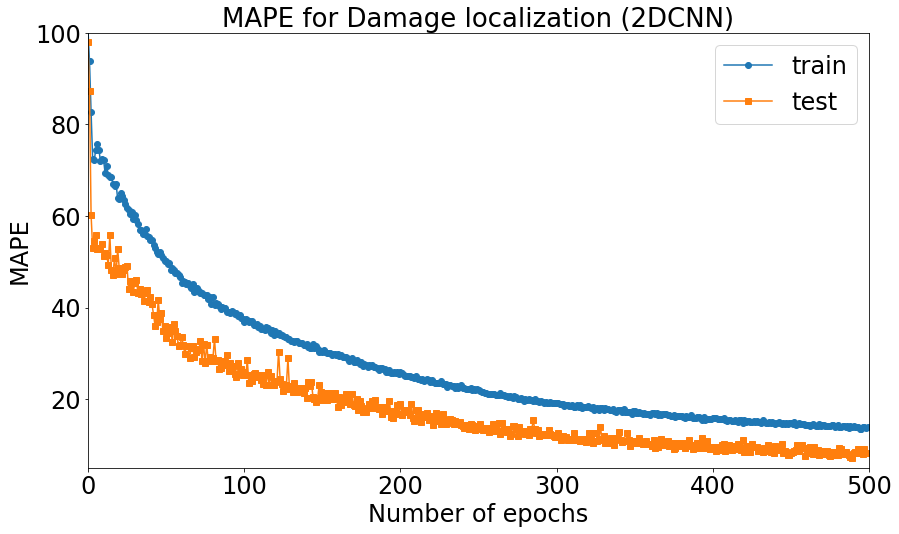

In [24]:
# for mape
plt.figure(figsize=(14,8))
plt.plot(epoch,MAPE,'-o')
plt.plot(epoch,MAPEval,'-s')
plt.title('MAPE for Damage localization (2DCNN)',fontsize=26)
plt.ylabel('MAPE',fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel('Number of epochs',fontsize=24)
plt.legend(['train', 'test'], loc='upper right',fontsize=24)
plt.axis([0,500,5, 100])
plt.show()

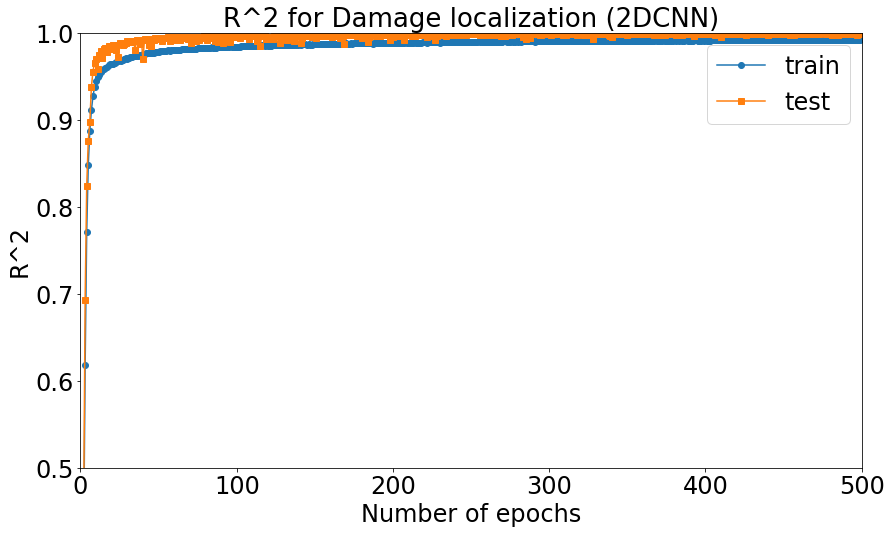

In [25]:
# for R2
plt.figure(figsize=(14,8))
plt.plot(epoch,R2,'-o')
plt.plot(epoch,R2val,'-s')
plt.title('R^2 for Damage localization (2DCNN)',fontsize=26)
plt.ylabel('R^2',fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel('Number of epochs',fontsize=24)
plt.legend(['train', 'test'], loc='upper right',fontsize=24)
plt.axis([0,500,0.5, 1.0])
plt.show()

In [28]:
# make predictions on the testing data
y_pred = model.predict(testImages)
y_pred = np.array(y_pred)
y_true = testY
diff = y_pred - y_true
percentDiff = (diff / y_true) * 100
absPercentDiff = pd.DataFrame(np.abs(percentDiff))
APD = round(absPercentDiff,2)
print(APD)

        0      1
0    0.81  28.96
1    0.20   2.61
2    2.02   0.03
3    0.95   0.32
4    4.92  28.78
..    ...    ...
495  5.56   3.81
496  0.53   6.13
497  8.32   3.35
498  0.06   8.84
499  0.34   4.09

[500 rows x 2 columns]


In [29]:
import xlsxwriter 

workbook = xlsxwriter.Workbook('2DCNN_DamLocal.xlsx') 
  
# By default worksheet names in the spreadsheet will be  
# Sheet1, Sheet2 etc., but we can also specify a name. 
worksheet = workbook.add_worksheet("My sheet") 

worksheet.write(0, 0, 'True values (x)') 
worksheet.write(0, 1, 'True values (a)')
worksheet.write(0, 2, 'Predicted values (x)') 
worksheet.write(0, 3, 'Predicted values (a)')
worksheet.write(0, 4, 'APD (x)') 
worksheet.write(0, 5, 'APD (a)') 


# columns are indexed from 1. 
row = 1
col = 0

y_true = np.array(y_true)
APD = np.array(APD)
# Iterate over the data and write it out row by row. 
for i in range(0, len(y_true)):
    worksheet.write(row, col, y_true[i,0])
    worksheet.write(row, col + 1, y_true[i,1]) 
    worksheet.write(row, col + 2, y_pred[i,0])
    worksheet.write(row, col + 3, y_pred[i,1])
    worksheet.write(row, col + 4, APD[i,0]) 
    worksheet.write(row, col + 5, APD[i,1])
    row += 1
  
workbook.close()

excel = pd.read_excel('2DCNN_DamLocal.xlsx')
print(excel)

     True values (x)  True values (a)  Predicted values (x)  \
0         482.653061         8.877551            478.758789   
1         758.163265        70.918367            759.644470   
2         620.408163        65.102041            632.967041   
3         773.469388        86.428571            780.825562   
4         712.244898        45.714286            747.271484   
..               ...              ...                   ...   
495       145.918367        43.775510            154.026794   
496       773.469388        14.693878            769.339233   
497       100.000000        47.653061             91.679070   
498       773.469388        34.081633            772.985779   
499       696.938776        39.897959            694.577393   

     Predicted values (a)  APD (x)  APD (a)  
0                6.306719     0.81    28.96  
1               72.768311     0.20     2.61  
2               65.082390     2.02     0.03  
3               86.147896     0.95     0.32  
4            

# Generalization on frequencies

In [39]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import glob
import cv2
import os

def load_pred_labels(inputPathT):
	# initialize the list of column names in the CSV file and then
	# load it using Pandas
	cols = ["x", "a"]
	dfT = pd.read_csv(inputPathT, header=None, names=cols)
	# return the data frame
	return dfT

In [40]:
def load_pred_images(dfT,pathT):
    images = []
    for i in dfT.index.values:
        base = os.path.sep.join([pathT, "D150_{}.png".format(i + 1)]) # for S0 images --> "{}_CgS0.png"
        #print(base)
        image = cv2.imread(base) # read the path using opencv
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (150, 150))
        #plt.imshow(image) # use matplotlib to plot the image
        #image = image[:,:,np.newaxis] #This is convert (600,600) --> (600,600,1)
        images.append(image) 
    return np.array(images)

In [41]:
# import the necessary packages
from sklearn.model_selection import train_test_split
from keras.layers.core import Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import concatenate
import numpy as np
import argparse
import locale
import os

mainpathT = 'D:/SDE/1_SDEisotropicDL/CollectData/4_TestSet/f150/3Labels/labels150.csv'
inputPathT = os.path.join(mainpathT)
pathT = 'D:/SDE/1_SDEisotropicDL/CollectData/4_TestSet/f150/4CWT'
dfT = load_pred_labels(inputPathT)
predImages = load_pred_images(dfT, pathT)
predImages = predImages / 255.0

In [42]:
print("Pred images...",predImages.shape)
print("Pred labels..",dfT.shape)

Pred images... (225, 150, 150, 3)
Pred labels.. (225, 2)


In [43]:
# make predictions on the testing data
y_pred = model.predict(predImages)
y_pred = np.array(y_pred)
y_true = dfT
diff = y_pred - y_true
percentDiff = (diff / y_true) * 100
absPercentDiff = np.abs(percentDiff)
APD = round(absPercentDiff,2)
print(APD)

          x       a
0    297.94  233.96
1    290.22  183.58
2    273.20  186.12
3    257.12  156.17
4    274.26  120.36
..      ...     ...
220   47.69   38.42
221   48.71   48.24
222   53.06   19.68
223   55.95   22.79
224   35.09   25.56

[225 rows x 2 columns]


In [44]:
import xlsxwriter 

workbook = xlsxwriter.Workbook('2DCNN_DamLocal_pred150.xlsx') 
  
# By default worksheet names in the spreadsheet will be  
# Sheet1, Sheet2 etc., but we can also specify a name. 
worksheet = workbook.add_worksheet("My sheet") 

worksheet.write(0, 0, 'True values (x)') 
worksheet.write(0, 1, 'True values (a)')
worksheet.write(0, 2, 'Predicted values (x)') 
worksheet.write(0, 3, 'Predicted values (a)')
worksheet.write(0, 4, 'APD (x)') 
worksheet.write(0, 5, 'APD (a)') 


# columns are indexed from 1. 
row = 1
col = 0

y_true = np.array(y_true)
APD = np.array(APD)
# Iterate over the data and write it out row by row. 
for i in range(0, len(y_true)):
    worksheet.write(row, col, y_true[i,0])
    worksheet.write(row, col + 1, y_true[i,1]) 
    worksheet.write(row, col + 2, y_pred[i,0])
    worksheet.write(row, col + 3, y_pred[i,1])
    worksheet.write(row, col + 4, APD[i,0]) 
    worksheet.write(row, col + 5, APD[i,1])
    row += 1
  
workbook.close()

excel = pd.read_excel('2DCNN_DamLocal_pred150.xlsx')
print(excel)

     True values (x)  True values (a)  Predicted values (x)  \
0              100.0        20.000000            397.936981   
1              100.0        24.642857            390.224335   
2              100.0        29.285714            373.198059   
3              100.0        33.928571            357.124603   
4              100.0        38.571429            374.261475   
..               ...              ...                   ...   
220            850.0        66.428571            444.609253   
221            850.0        71.071429            435.995422   
222            850.0        75.714286            399.029785   
223            850.0        80.357143            374.464905   
224            850.0        85.000000            551.768738   

     Predicted values (a)  APD (x)  APD (a)  
0               66.792442   297.94   233.96  
1               69.881943   290.22   183.58  
2               83.791801   273.20   186.12  
3               86.914322   257.12   156.17  
4            